In [3]:
import pandas as pd
import numpy as np
# from com_var import *
# import wave_process
# import ta_feature
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import  *
from tensorflow.keras.callbacks import EarlyStopping
# from time_series import df_to_X_y2future,df_to_X_y2
from tradingview_ta import TA_Handler, Interval, Exchange
import yfinance as yf
import talib as ta

window_size=120
batch_size=120
lop=1
v="index" if lop==1 else  "Datetime"
o=1

In [28]:
def getrecommendation(ticker,time):
    
    tesla = TA_Handler(
        symbol=ticker,
        screener="forex",
        exchange="FX_IDC",
        interval=time,
        # proxies={'http': 'http://0.0.0.0:8080', 'https': 'https://0.0.0.0:443'}
    )
    print(tesla.get_analysis().summary)
    print(ta_select[tesla.get_analysis().summary["recommendation".upper()].upper()])

In [29]:
ta_select={"STRONG_BUY":1,"BUY":1,"NEUTRAL":0,"SELL":-1,"STRONG_SELL":-1}

In [30]:
getrecommendation("audusd","1d")

{'RECOMMENDATION': 'SELL', 'BUY': 2, 'SELL': 15, 'NEUTRAL': 8}
-1


In [12]:

# def df_to_X_y2(df, window_size=12,nfuture=2):
#     k=df.reset_index()
#     df_as_np = df.to_numpy()
#     X = []
#     y = []
#     ko=0 if o==1 else o
#     xlast=[]
#     dates=[]
#     r=len(df_as_np)-window_size-nfuture+1 if nfuture>1 else len(df_as_np)-window_size
#     for i in range(r):
#         row = [r for r in df_as_np[i:i+window_size]]
#         X.append(row)
#         label =[[r[ko]] for r in df_as_np[i+window_size:i+window_size+nfuture]] if nfuture>1 else df_as_np[i+window_size][:ko]
#         xlast.append(df_as_np[i+window_size-1][3])
#         y.append(label)
#         date=k[v][i+window_size:i+window_size+nfuture].values if nfuture>1 else k[v][i+window_size]
#         dates.append(date)
#     X=np.asarray(X)
#     y=np.asarray(y)
    
#     print(f"hii X {X.shape}, y {y.shape}")
#     return X,y,dates,xlast

In [237]:
def df_to_X_y2(df, window_size=6):
    print(df.shape)
    k=df.reset_index()
    ko=o
    ko=0 if o==1 else o
    l= 0 if o==1 else 3
    

    df_as_np = df.to_numpy()
    dates=[]
    X = []
    y = []
    xlast=[]
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)

        label =[df_as_np[i+window_size][ko]] if o==1 else df_as_np[i+window_size][:ko]
        y.append(label)
        dates.append(k[v][i+window_size])
        xlast.append([row[-1][l]])
    X=np.asarray(X)
    y=np.asarray(y)
    
    print(f"hii X {X.shape}, y {y.shape}")
    return X,y,dates,xlast


In [238]:

def technicalIndicators(data):
    data["MA"]=ta.MA(data['Close'], timeperiod=14, matype=0)
    data['Close_wave'],data['High_wave'],data['Low_wave'],\
    data['Open_wave']=wave_process.denoising([data['Close'],data['High'],data['Low'],data['Open']])
    
    data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data['Close'], \
                                                                 fastperiod=7, slowperiod=14, signalperiod=5)
  
    data['CCI14'] = ta.CCI(data['High'], data['Low'], data['Close'], timeperiod=14)
   

    
    data['ATR14'] = ta.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
    data['NATR14']=ta.NATR(data['High'], data['Low'], data['Close'], timeperiod=14)
    data["DEMA"]=ta.DEMA(data['Close'], timeperiod=14)

    data["BBupper"],data["BBmidle"],data["BBlower"]=ta.BBANDS(data['Close'], timeperiod=10, nbdevup=2, nbdevdn=2, matype=0)
    data["EMA10"]=ta.EMA(data['Close'], timeperiod=10)
    data["EMA30"]=ta.EMA(data['Close'], timeperiod=30)
    data["MOM"] = ta.MOM(data['Close'], timeperiod=14)
    
    data['ROC']=ta.ROC(data['Close'], timeperiod=14)
    data['KAMA']=ta.KAMA(data['Close'], timeperiod=14)

    data["WillR"]=ta.WILLR(data['High'], data['Low'], data['Close'], timeperiod=14)
    
    # data["Pattern"]=ta.CDLCOUNTERATTACK(data['Open'],data['High'], data['Low'], data['Close'])



    return data


In [239]:

def getdata(ticker):
# Get the data
    li=["Adj Close","Volume","Open","High","Low"] if o==1 else ["Adj Close","Volume"]
    data = yf.download(tickers=ticker+"=X",period="730d" ,interval="1h",progress=True)
    data=data.drop(li,axis=1)
    
    data=technicalIndicators(data)
    data.dropna(how='any', inplace=True)
    data = data[data.shape[0] % batch_size:]
    validation_size1=round(data.shape[0]/6)
    test_size1=validation_size1
    test_size1

    df_train =data[:- validation_size1*2].copy(deep=True)
    df_validation = data[- validation_size1*2 :- test_size1].copy(deep=True)
    df_test = data[- test_size1 :].copy(deep=True)
    print(f'df_train.shape {df_train.shape}, df_validation.shape {df_validation.shape}, df_test.shape {df_test.shape}')
    return df_train,df_validation,df_test,data





In [240]:

def preprocess(df_train,df_test,df_validation,scaler = MinMaxScaler()):

    
    train_values=df_train.iloc[:,:].copy(deep=True)
    val_values=df_validation.iloc[:,:].copy(deep=True)
    test_values=df_test.iloc[:,:].copy(deep=True)
    train_values.iloc[:,:] = scaler.fit_transform(train_values)[:,:]
    val_values.iloc[:,:]=scaler.fit_transform(val_values)[:,:]
    test_values.iloc[:,:]=scaler.fit_transform(test_values)[:,:]
    X,y,dx,xtl=df_to_X_y2(train_values,window_size)
    x_val,y_val,dv,xvl=df_to_X_y2(val_values,window_size)
    x_test,y_test,dt,xtsl=df_to_X_y2(test_values,window_size)

    return X,y,x_val,y_val,x_test,y_test,train_values,val_values,test_values,scaler,dx,dv,dt,xtsl


In [234]:
import time
import os.path


  
# # store starting time
# begin = time.time()
ticker="gbpusd"
df_train,df_val,df_test,data=getdata(ticker)
epochs = 40
np.random.seed(seed)
tf.random.set_seed(seed)

file_exists = os.path.exists('readme.txt')
# if file_exists:
#     xtrain,ytrain,xval,yval,ttable,vtable,scaler=preprocess(df_train=df_train,df_validation=df_validation)
#     model = tf.keras.models.load_model(model_path)
# else:
xtrain,ytrain,xval,yval,xtest,ytest,ttable,valtble,testtble,scaler,dx,dv,dt,xtsl=preprocess(df_train=df_train,df_validation=df_val,df_test=df_test)

maincolumn=xtrain.shape[2]


[*********************100%***********************]  1 of 1 completed
df_train.shape (11520, 25), df_validation.shape (2880, 25), df_test.shape (2880, 25)
(11520, 25)
hii X (11400, 120, 25), y (11400, 4)
(2880, 25)
hii X (2760, 120, 25), y (2760, 4)
(2880, 25)
hii X (2760, 120, 25), y (2760, 4)


In [235]:
from tensorflow import keras
from tensorflow.keras import layers
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


In [163]:

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,o=1
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(o)(x)
    return keras.Model(inputs, outputs)


In [164]:
def getrocketmodel(xtrain,o):
    input_shape = xtrain.shape[1:]

    model1 = build_model(input_shape,head_size=256,num_heads=8,ff_dim=4,num_transformer_blocks=4,mlp_units=[128],mlp_dropout=0.4,dropout=0.25,o=o)

    model1.compile(loss="mse",optimizer=keras.optimizers.SGD(),metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()],)
    model1.summary()
    return model1

In [165]:

model1=getrocketmodel(xtrain,o)


model1.fit(
    xtrain,
    ytrain,
    validation_data=(xval, yval), epochs = epochs,batch_size=batch_size, shuffle=False,verbose=1,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
)

model1.evaluate(xval, yval, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 25)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 20, 25)      50          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 20, 25)      210969      ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

[0.004331214819103479, 0.06581196933984756, 0.05251243710517883]

In [166]:

def getmodel():        
    model = Sequential()

    model = Sequential()
    forward_layer = GRU(60, return_sequences=True,kernel_regularizer=tf.keras.regularizers.L1(0.02))
    backward_layer = LSTM(34, return_sequences=True, go_backwards=True)
    model.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(window_size, maincolumn)))
    model.add(Conv1D(20, kernel_size=2))

    model.add(Dropout(0.2))
    # model.add(Bidirectional(LSTM(64,return_sequences = True)))
    model.add(LSTM(16,return_sequences=True))
    model.add(Conv1D(8, kernel_size=2))
    model.add(Flatten())

    model.add(Dense(4))
    model.add(Dense(o))



    model.compile(
        optimizer='sgd',
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])
    model.build()

    print(model.summary())
    return model


In [167]:
model=getmodel()
# model = tf.keras.models.load_model(model_path)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 20, 94)           23820     
 l)                                                              
                                                                 
 conv1d_8 (Conv1D)           (None, 19, 20)            3780      
                                                                 
 dropout_9 (Dropout)         (None, 19, 20)            0         
                                                                 
 lstm_1 (LSTM)               (None, 19, 16)            2368      
                                                                 
 conv1d_9 (Conv1D)           (None, 18, 8)             264       
                                                                 
 flatten (Flatten)           (None, 144)               0         
                                                      

In [168]:


history=model.fit(xtrain, ytrain,validation_data=(xval, yval), epochs = epochs,batch_size=batch_size, shuffle=False,verbose=1,callbacks=EarlyStopping( patience=3, restore_best_weights=True))
# model.save('models/lstm{ticker}-{}')
# joblib.dump(scaler, scaler_path) 

# total time taken


Epoch 1/40
576/576 [==============================] - 19s 22ms/step - loss: 3.7439 - root_mean_squared_error: 0.0864 - mean_absolute_error: 0.0605 - val_loss: 0.8975 - val_root_mean_squared_error: 0.2420 - val_mean_absolute_error: 0.2238
Epoch 2/40
576/576 [==============================] - 10s 17ms/step - loss: 0.1460 - root_mean_squared_error: 0.0527 - mean_absolute_error: 0.0392 - val_loss: 0.0805 - val_root_mean_squared_error: 0.2672 - val_mean_absolute_error: 0.2493
Epoch 3/40
576/576 [==============================] - 9s 16ms/step - loss: 0.0114 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0342 - val_loss: 0.0524 - val_root_mean_squared_error: 0.2077 - val_mean_absolute_error: 0.1925
Epoch 4/40
576/576 [==============================] - 10s 17ms/step - loss: 0.0108 - root_mean_squared_error: 0.0406 - mean_absolute_error: 0.0296 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1689 - val_mean_absolute_error: 0.1557
Epoch 5/40
576/576 [=============================

In [172]:
model1.save('models/{}-{}'.format("transformer","1h"))
model.save('models/{}-{}'.format("bi-lstm","1h"))
# joblib.dump(scaler, scaler_path) 

INFO:tensorflow:Assets written to: models/transformer-1h\assets


INFO:tensorflow:Assets written to: models/transformer-1h\assets


INFO:tensorflow:Assets written to: models/bi-lstm-1h\assets


INFO:tensorflow:Assets written to: models/bi-lstm-1h\assets


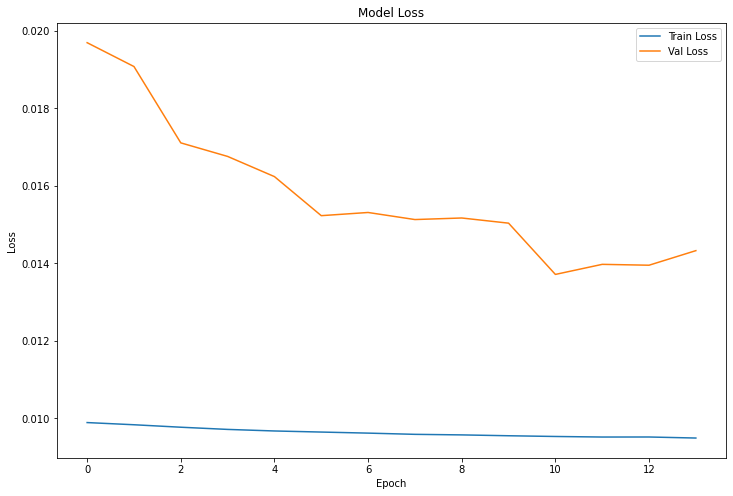

In [41]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.subplots(1)
ax1.set_title('Model Loss')
ax1.set(xlabel='Epoch', ylabel='Loss')
ax1.plot(history.history['loss'][7:], label='Train Loss')
ax1.plot(history.history['val_loss'][7:], label='Val Loss')

ax1.legend()

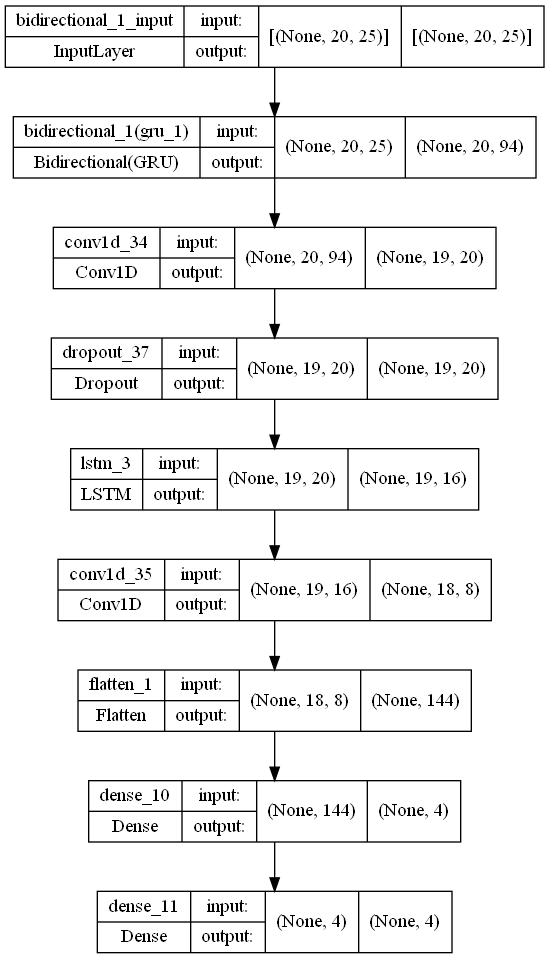

In [105]:
# from keras.utils.vis_utils import plot_model
# plot_model(model1, to_file='transformer_model_plot.png', show_shapes=True, show_layer_names=True)
# plot_model(model, to_file='bi_model_plot.png', show_shapes=True, show_layer_names=True)



In [43]:
mse = model1.evaluate(xtest, ytest, verbose=1)
msd=model.evaluate(xtest, ytest, verbose=1)
print("transformers", mse)
print("bi-lstm", msd)
# Mean Squared Error: [0.049819089472293854, 0.17464657127857208] <----- standardScaler()
# Mean Squared Error: [0.027022255584597588, 0.09141747653484344]<----- MinMaxScaler()
# Mean Squared Error: [0.0231696255505085, 0.06953272223472595]<------ using ohlc

# Mean Squared Error: [0.030867109075188637, 0.14459161460399628]<------- 1hour
# Mean Squared Error: [0.019924916326999664, 0.09962350130081177] <------ sdg
# Mean Squared Error: [0.029022160917520523, 0.1379862129688263]
# Mean Squared Error: [0.021181577816605568, 0.05693402141332626]<------ using ohlc and predicting ohlc
# Mean Squared Error: [0.013695263303816319, 0.09310127794742584, 0.0009837677935138345]

90/90 [==============================] - 1s 8ms/step - loss: 0.0116 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0404
transformers [0.002250437857583165, 0.04743878170847893, 0.03558425232768059]
bi-lstm [0.01157372910529375, 0.049358170479536057, 0.04040740430355072]


In [44]:
xtest.shape[2]

25

In [173]:
y_pred = model.predict(xtest)
y_pred1 = model1.predict(xtest)
# y_true=np.reshape(ytest, (ytest.shape[0], o)) 
y_true=ytest


In [174]:
y_pred.shape

(2863, 4)

In [175]:
def getinversescaler(pred,Sc):
    forcaste=np.repeat(pred,maincolumn,axis=1)
   
    forcaste=forcaste[:,:maincolumn]
    
    pred=Sc.inverse_transform(forcaste)
   
    return pred


In [176]:
dt=np.array(dt)


In [177]:
len(xtsl)

2863

In [178]:
xtsl=np.reshape(np.array(xtsl),(ytest.shape[0],1))

In [179]:
xtsl.shape

(2863, 1)

In [180]:
y_true.shape

(2863, 4)

In [181]:
true=getinversescaler(y_true,Sc=scaler)
pred=getinversescaler(y_pred,Sc=scaler)
pred1=getinversescaler(y_pred1,Sc=scaler)
xtsl=getinversescaler(xtsl,Sc=scaler)

In [182]:
# temp_df={"y_pred":pred[:,0],"y_true":true[:,0],"dates":dt[:,0],"p1":pred1[:,0],"t2":true1[:,0]}
temp_df={"y_pred":pred[:,3],"y_pred1":pred1[:,3],"y_true":true[:,0],"dates":dt[:],"xlast":xtsl[:,0]}
temp_df=pd.DataFrame.from_dict(temp_df)
temp_df=temp_df.set_index("dates")
temp_df

,y_pred,y_pred1,y_true,xlast
dates,,,,
2021-11-11 15:00:00+00:00,1.343129,1.344621,1.339872,1.340209
2021-11-11 16:00:00+00:00,1.342362,1.345345,1.339280,1.339404
2021-11-11 17:00:00+00:00,1.341579,1.344996,1.338401,1.338350
2021-11-11 18:00:00+00:00,1.340667,1.345181,1.336970,1.337227
2021-11-11 19:00:00+00:00,1.340027,1.345249,1.336612,1.337102
...,...,...,...,...
2022-04-28 18:00:00+01:00,1.261850,1.254636,1.246417,1.246944
2022-04-28 19:00:00+01:00,1.260836,1.254209,1.244818,1.245552
2022-04-28 20:00:00+01:00,1.259607,1.253136,1.245935,1.246697


In [183]:
temp_df["model1 acc"]=temp_df['y_pred1']/np.abs(temp_df["y_pred1"]+temp_df['y_true'])
temp_df["model acc"]=temp_df['y_pred']/np.abs(temp_df["y_pred"]+temp_df['y_true'])


In [184]:
temp_df.head()

,y_pred,y_pred1,y_true,xlast,model1 acc,model acc
dates,,,,,,
2021-11-11 15:00:00+00:00,1.343129,1.344621,1.339872,1.340209,0.500884,0.500607
2021-11-11 16:00:00+00:00,1.342362,1.345345,1.339280,1.339404,0.501130,0.500575
2021-11-11 17:00:00+00:00,1.341579,1.344996,1.338401,1.338350,0.501229,0.500593
2021-11-11 18:00:00+00:00,1.340667,1.345181,1.336970,1.337227,0.501531,0.500690
2021-11-11 19:00:00+00:00,1.340027,1.345249,1.336612,1.337102,0.501610,0.500638


In [185]:
import plotly.express as px
df=temp_df
fig = px.line(df, y=df.columns)

fig.show()
# fig=px.figure()
# fig.add_scattergl(x=temp_df.index.tolist(), y=temp_df["y_pred"], line={'color': 'black'})

# # Above threshhgold
# fig.add_scattergl(x=xs, y=df.y.where(df.y >= 1), line={'color': 'red'})

In [238]:
# y_true=yval
# # y_true= np.reshape(y_true, (y_true.shape[0], 1))
# # forcaste=np.repeat(y_pred,vtable.shape[1],axis=1)
# # real=np.repeat(y_true,vtable.shape[1],axis=1)
# y_pred=y_pred[:,0]
# y_true=scaler.inverse_transform(yval)[:,0]
fig = px.line(data, y=["Close","MA"])

fig.show()

In [144]:
d=np.array(xtest[-1:])
d.shape

(1, 20, 25)

In [132]:
def getss(ticker="gbpusd=x",ppp=25):
    data = yf.download(tickers=ticker,period="5d" ,interval="1h",progress=True)
    data=data.drop(["Adj Close","Volume"],axis=1)

    data=technicalIndicators(data)
    data.dropna(how='any', inplace=True)
    data = data[data.shape[0] % batch_size:]
    print(data.shape)
    return data[:-ppp],data[-ppp:]

In [187]:
model1 = tf.keras.models.load_model('models/{}-{}'.format("transformer","1h"))
model=tf.keras.models.load_model('models/{}-{}'.format("bi-lstm","1h"))

In [188]:
next=60
newtable,check=getss("gbpusd=X",next)
newtable.shape
newtable1,check1=getss("gbpusd=X",next)

[*********************100%***********************]  1 of 1 completed
(80, 25)
[*********************100%***********************]  1 of 1 completed
(80, 25)


In [189]:

for i in range(next):
    X=newtable.iloc[-window_size:,:].copy(deep=True)
    X1=newtable1.iloc[-window_size:,:].copy(deep=True)
    Scalerc=MinMaxScaler()
    Scalerc1=MinMaxScaler()
    X.iloc[:,:]=Scalerc.fit_transform(X)[:,:]
    X1.iloc[:,:]=Scalerc1.fit_transform(X1)[:,:]
    Xn=np.asarray([X[:]])
    Xn1=np.asarray([X1[:]])
    last_date = newtable.iloc[[-1]].index
    last_date =  pd.DatetimeIndex(last_date) + pd.Timedelta(1,"h")
    ypredn = model.predict(Xn)
    ypredn1 = model1.predict(Xn1)
    ypredn=getinversescaler(ypredn,Scalerc)[0:]
    ypredn1=getinversescaler(ypredn1,Scalerc1)[0:]
    
    newtable=newtable.append(pd.DataFrame(ypredn,index=last_date,columns=newtable.columns.to_list()))
    newtable1=newtable1.append(pd.DataFrame(ypredn1,index=last_date,columns=newtable1.columns.to_list()))



C:\Users\harsh\AppData\Local\Temp\ipykernel_9396\1637682782.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\harsh\AppData\Local\Temp\ipykernel_9396\1637682782.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\harsh\AppData\Local\Temp\ipykernel_9396\1637682782.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\harsh\AppData\Local\Temp\ipykernel_9396\1637682782.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\harsh\AppData\Local\Temp\ipykernel_9396\1637682782.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

In [190]:
newtable.tail()

,Open,High,Low,Close,MA,Close_wave,High_wave,Low_wave,Open_wave,macd,...,DEMA,BBupper,BBmidle,BBlower,EMA10,EMA30,MOM,ROC,KAMA,WillR
2022-04-28 18:00:00+01:00,1.274226,1.274989,1.273148,1.273916,1.274472,1.273531,1.274797,1.272946,1.274251,-0.000269,...,1.273811,1.277641,1.274570,1.272061,1.274396,1.278673,0.001239,0.098330,1.274969,-50.459251
2022-04-28 19:00:00+01:00,1.274229,1.274992,1.273152,1.273921,1.274473,1.273535,1.274800,1.272949,1.274254,-0.000284,...,1.273813,1.277643,1.274571,1.272062,1.274397,1.278676,0.001156,0.091902,1.274970,-50.376705
2022-04-28 20:00:00+01:00,1.274229,1.275003,1.273169,1.273938,1.274465,1.273551,1.274813,1.272963,1.274262,-0.000289,...,1.273777,1.277627,1.274543,1.272040,1.274386,1.278664,0.001130,0.089874,1.274968,-50.092419
2022-04-28 21:00:00+01:00,1.274228,1.275000,1.273166,1.273935,1.274457,1.273551,1.274812,1.272963,1.274262,-0.000289,...,1.273777,1.277612,1.274543,1.272040,1.274386,1.278660,0.001129,0.089801,1.274964,-50.124062
2022-04-28 22:00:00+01:00,1.274236,1.274999,1.273164,1.273930,1.274449,1.273550,1.274812,1.272962,1.274261,-0.000291,...,1.273774,1.277595,1.274541,1.272038,1.274385,1.278650,0.001119,0.089020,1.274963,-50.214798


In [191]:
newtable1.tail()

,Open,High,Low,Close,MA,Close_wave,High_wave,Low_wave,Open_wave,macd,...,DEMA,BBupper,BBmidle,BBlower,EMA10,EMA30,MOM,ROC,KAMA,WillR
2022-04-28 18:00:00+01:00,1.273904,1.274726,1.272857,1.273599,1.274234,1.273223,1.274513,1.272606,1.273947,-0.000440,...,1.273648,1.277394,1.274421,1.272016,1.274368,1.278043,0.000239,0.021276,1.274907,-56.952915
2022-04-28 19:00:00+01:00,1.273890,1.274727,1.272859,1.273601,1.274230,1.273225,1.274515,1.272607,1.273948,-0.000446,...,1.273635,1.277383,1.274414,1.272009,1.274363,1.278052,0.000142,0.013648,1.274905,-56.910439
2022-04-28 20:00:00+01:00,1.273865,1.274725,1.272864,1.273598,1.274203,1.273222,1.274513,1.272605,1.273946,-0.000462,...,1.273605,1.277349,1.274387,1.271974,1.274348,1.278025,0.000124,0.012291,1.274897,-56.974567
2022-04-28 21:00:00+01:00,1.273871,1.274727,1.272866,1.273600,1.274207,1.273224,1.274515,1.272607,1.273948,-0.000458,...,1.273611,1.277321,1.274392,1.271980,1.274351,1.277987,0.000141,0.013579,1.274899,-56.913666
2022-04-28 22:00:00+01:00,1.273879,1.274730,1.272870,1.273605,1.274214,1.273228,1.274518,1.272611,1.273951,-0.000454,...,1.273620,1.277339,1.274400,1.271989,1.274355,1.278002,0.000166,0.015544,1.274901,-56.820827


In [192]:
check.head()

,Open,High,Low,Close,MA,Close_wave,High_wave,Low_wave,Open_wave,macd,...,DEMA,BBupper,BBmidle,BBlower,EMA10,EMA30,MOM,ROC,KAMA,WillR
2022-04-26 11:00:00+01:00,1.271310,1.272475,1.270696,1.271230,1.274037,1.270299,1.272149,1.269766,1.271559,-0.000845,...,1.272209,1.278131,1.273920,1.269708,1.273060,1.275813,-0.002916,-0.228830,1.274551,-90.314740
2022-04-26 12:00:00+01:00,1.271472,1.271585,1.268746,1.268746,1.273627,1.269606,1.271598,1.269042,1.270934,-0.001185,...,1.271201,1.278506,1.273328,1.268149,1.272275,1.275357,-0.005740,-0.450400,1.273950,-100.000000
2022-04-26 13:00:00+01:00,1.268987,1.268987,1.267604,1.268006,1.273190,1.268369,1.270556,1.267787,1.269807,-0.001452,...,1.270217,1.278176,1.272507,1.266839,1.271499,1.274883,-0.006123,-0.480578,1.273298,-95.836731
2022-04-26 14:00:00+01:00,1.268006,1.269761,1.266785,1.268392,1.272796,1.266498,1.268917,1.265919,1.268089,-0.001532,...,1.269534,1.277096,1.271681,1.266267,1.270934,1.274464,-0.005510,-0.432518,1.272851,-84.650861
2022-04-26 15:00:00+01:00,1.268183,1.268183,1.261989,1.262084,1.271887,1.264226,1.266848,1.263667,1.265968,-0.002270,...,1.267432,1.277359,1.270274,1.263188,1.269325,1.273665,-0.012726,-0.998299,1.270573,-99.373672


In [193]:
check.Close[-10:]

2022-04-28 13:00:00+01:00    1.242761
2022-04-28 14:00:00+01:00    1.243626
2022-04-28 15:00:00+01:00    1.243982
2022-04-28 16:00:00+01:00    1.243719
2022-04-28 17:00:00+01:00    1.246448
2022-04-28 18:00:00+01:00    1.245051
2022-04-28 19:00:00+01:00    1.246199
2022-04-28 20:00:00+01:00    1.246743
2022-04-28 21:00:00+01:00    1.246634
2022-04-28 21:38:33+01:00    1.246619
Name: Close, dtype: float64

In [194]:
fig=px.line(newtable,y=["Close"])
fig.show()

In [195]:
df=newtable
# fig = px.line(x=df[-next:].index, y=[df["Close"][-next:],check["Close"]],)
fig = px.line(x=df[-next:].index, y=[df["Close"][-next:],newtable1["Close"][-next:],check["Close"]],)
series_names=["pred_model","true"]
for idx, name in enumerate(series_names):
    fig.data[idx].name = name
    # fig.data[idx].hovertemplate = name
# fig.add_trace(fig.add_scatter(x=check.index, y=check["Close"]))
# fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [152]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 20, 94)           23820     
 nal)                                                            
                                                                 
 conv1d_34 (Conv1D)          (None, 19, 20)            3780      
                                                                 
 dropout_37 (Dropout)        (None, 19, 20)            0         
                                                                 
 lstm_3 (LSTM)               (None, 19, 16)            2368      
                                                                 
 conv1d_35 (Conv1D)          (None, 18, 8)             264       
                                                                 
 flatten_1 (Flatten)         (None, 144)               0         
                                                      

In [153]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 20, 94)           23820     
 nal)                                                            
                                                                 
 conv1d_34 (Conv1D)          (None, 19, 20)            3780      
                                                                 
 dropout_37 (Dropout)        (None, 19, 20)            0         
                                                                 
 lstm_3 (LSTM)               (None, 19, 16)            2368      
                                                                 
 conv1d_35 (Conv1D)          (None, 18, 8)             264       
                                                                 
 flatten_1 (Flatten)         (None, 144)               0         
                                                      

In [218]:
# def getinversescalerfuture(true,pred,dates):
#     dt=np.asarray(dates)
#     d1=[i[0][0] for i in dt]
#     d2=[i[0][1] for i in dt]
#     ytt1=[]
#     ypt1=[]
#     ytt2=[]
#     ypt2=[]
   
#     for i in true:
#         ytt1.append(i[0])
#         ytt2.append(i[1])
        
#     for i in pred:
#         ypt1.append(i[0])
#         ypt2.append(i[1])
#     t1=np.repeat(ytt1,maincolumn,axis=1)
#     t1=t1[:,:maincolumn]
#     t1=scaler.inverse_transform(t1)[:,:]
#     t2=np.repeat(ytt2,maincolumn,axis=1)
#     t2=t2[:,:maincolumn]
#     t2=scaler.inverse_transform(t2)[:,:]
#     p1=np.repeat(ypt1,maincolumn,axis=1)
#     p1=p1[:,:maincolumn]
#     p1=scaler.inverse_transform(p1)[:,:]
#     p2=np.repeat(ypt2,maincolumn,axis=1)
#     p2=p2[:,:maincolumn]
#     p2=scaler.inverse_transform(p2)[:,:]

#     return t1,p1,d1,t2,p2,d2


# lastx=np.asarray(xtsl)
# lastx=np.reshape(lastx, (lastx.shape[0], 1))
# lastx=np.repeat(lastx,maincolumn,axis=1)
# lastx=lastx[:,:24]
# lastx=scaler.inverse_transform(lastx)[:,0]
# t1,p1,d1,t2,p2,d2=getinversescalerfuture(y_true,y_pred,dt)  
# 
# temp_df={"y_pred1":p2[:,3],"y_pred":p1[:,3],"y_true":t1[:,3],"y_true1":t2[:,3],"dates":d1,"dates1":d2,"lastx":lastx}
# temp_df=pd.DataFrame.from_dict(temp_df)
# temp_df=temp_df.set_index("dates")
# temp_df 

In [211]:
testingcontext={"Symbolname":"gbpusd","Cost":0.00015000000000000001,"pipval":0.0001,"Pridiction_size":4,"Open":[1.30074,1.3006,1.30051,1.29968,1.30047,1.29988,1.29969,1.30067,1.3015,1.30404,1.30287,1.30296,1.30166,1.3001,1.30023,1.29892,1.30099,1.3007,1.29996,1.29988,1.30024,1.29955,1.29973,1.30098,1.3014,1.30188,1.30284,1.30298,1.3041,1.30363,1.30295,1.30234,1.30009,1.30295,1.30312,1.30574,1.3052,1.3055,1.3052,1.30472,1.30536,1.30508,1.30577,1.30562,1.3063,1.30494,1.30573,1.30729,1.30668,1.30527],"High":[1.3019,1.30108,1.30067,1.30071,1.30095,1.30021,1.30109,1.30161,1.304,1.30408,1.30349,1.30298,1.30245,1.3005,1.30078,1.30121,1.30116,1.30149,1.3002,1.30028,1.30025,1.29987,1.30089,1.30144,1.30203,1.30308,1.30367,1.30452,1.30437,1.30366,1.30383,1.30234,1.30318,1.30415,1.30662,1.30616,1.30577,1.30655,1.30612,1.30589,1.30649,1.30579,1.30708,1.30652,1.3069,1.30644,1.30735,1.30733,1.30683,1.30527],"Low":[1.30024,1.30008,1.29892,1.29937,1.29932,1.29877,1.29885,1.30012,1.30114,1.30237,1.30143,1.30053,1.2997,1.29805,1.29879,1.29872,1.30017,1.2999,1.29918,1.29918,1.29964,1.29903,1.29973,1.30047,1.30115,1.3011,1.30234,1.30293,1.30334,1.30273,1.30162,1.30006,1.29963,1.30227,1.30304,1.30487,1.30327,1.30469,1.30343,1.30366,1.30462,1.30491,1.30533,1.30535,1.30614,1.30445,1.30573,1.30638,1.30468,1.30527],"Close":[1.3006,1.30052,1.29967,1.30047,1.29989,1.29972,1.30069,1.30149,1.304,1.30286,1.30296,1.30164,1.3001,1.30021,1.29894,1.30095,1.3007,1.29997,1.29989,1.30023,1.2999,1.29976,1.30089,1.30139,1.30188,1.30287,1.30294,1.30411,1.30363,1.30297,1.30234,1.30009,1.30294,1.30312,1.30574,1.30519,1.30549,1.3052,1.30471,1.30537,1.30506,1.30576,1.30563,1.30634,1.30678,1.30587,1.30727,1.30678,1.30525,1.30527]}

In [212]:
import pandas as pd
def getdataframe(context):
    data= pd.DataFrame({"Open":context["Open"],"High":context["High"],"Low":context["Low"],"Close":context["Close"]})
    data=technicalIndicators(data)
    data.dropna(how='any', inplace=True)
    data = data[data.shape[0] % batch_size:]
    data.reset_index(inplace=True)
    data.drop("index",axis=1,inplace=True)

    return data
    
    



In [213]:
dff=getdataframe(testingcontext)

c:\Users\harsh\Desktop\sem 8 final project\code\final\lib\site-packages\pywt\_multilevel.py:43: UserWarning:

Level value of 2 is too high: all coefficients will experience boundary effects.



In [214]:
pip=0.0001

In [219]:
newtable=getdataframe(testingcontext)
next=2

c:\Users\harsh\Desktop\sem 8 final project\code\final\lib\site-packages\pywt\_multilevel.py:43: UserWarning:

Level value of 2 is too high: all coefficients will experience boundary effects.



In [220]:
maincolumn=25
def getpredictednew(next,data):
    newtable=data.copy(deep=True)
    for i in range(next):
        X=newtable.iloc[-window_size:,:].copy(deep=True)
        # X1=newtable1.iloc[-window_size:,:].copy(deep=True)
        Scalerc=MinMaxScaler()
        # Scalerc1=MinMaxScaler()
        X.iloc[:,:]=Scalerc.fit_transform(X)[:,:]
        # X1.iloc[:,:]=Scalerc1.fit_transform(X1)[:,:]
        Xn=np.asarray([X[:]])
        # Xn1=np.asarray([X1[:]])
        # last_date = newtable.iloc[[-1]].index
        # last_date =  pd.DatetimeIndex(last_date) + pd.Timedelta(1,"h")
        ypredn = model.predict(Xn)
        # ypredn1 = model1.predict(Xn1)
        ypredn=getinversescaler(ypredn,Scalerc)[0:]
        # ypredn1=getinversescaler(ypredn1,Scalerc1)[0:]
        newtable=newtable.append(pd.DataFrame(ypredn,index=newtable.iloc[-1:].index+1,columns=newtable.columns.to_list()))
        # newtable1=newtable1.append(pd.DataFrame(ypredn1,index=last_date,columns=newtable1.columns.to_list()))
    return newtable


In [225]:
newtable=getpredictednew(4,newtable)

C:\Users\harsh\AppData\Local\Temp\ipykernel_9396\1572155542.py:19: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\harsh\AppData\Local\Temp\ipykernel_9396\1572155542.py:19: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\harsh\AppData\Local\Temp\ipykernel_9396\1572155542.py:19: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\harsh\AppData\Local\Temp\ipykernel_9396\1572155542.py:19: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [222]:
fig=px.line(newtableo,y=["Close"])
fig.show()

In [227]:
newtable.columns

Index(['Open', 'High', 'Low', 'Close', 'MA', 'Close_wave', 'High_wave',
       'Low_wave', 'Open_wave', 'macd', 'macdsignal', 'macdhist', 'CCI14',
       'ATR14', 'NATR14', 'DEMA', 'BBupper', 'BBmidle', 'BBlower', 'EMA10',
       'EMA30', 'MOM', 'ROC', 'KAMA', 'WillR'],
      dtype='object')

In [206]:
pred=newtable[-4:-3].Close.values[0]
pred1=newtable[-1:].Close.values[0]

In [210]:
30*pip*0.1

0.00030000000000000003

In [209]:
abs(pred-pred1)

0.00042569637298583984

In [208]:
abs(pred-pred1)>30*pip

False